# **Autism Spectrum Disorder Behavioral Gesture Classification Using Machine Learning**

**Problem Statement:**

Autism Spectrum Disorder (ASD) often involves distinctive behavioral gestures such as screaming, crying, and stimming, which are important indicators of emotional state. Manual monitoring of these behaviors is time-consuming, subjective, and not always feasible in real-world environments. There is a need for an automated system that can recognize and classify ASD-related gestures from images. However, the available dataset is small and slightly imbalanced, making deep learning approaches less suitable. This project aims to develop a reliable machine learning-based solution to accurately classify ASD behavioral gestures using handcrafted feature engineering.

In [104]:
# Environment Setup
!pip install mediapipe==0.10.31
!wget -O /content/hand_landmarker.task https://storage.googleapis.com/mediapipe-assets/hand_landmarker.task

--2026-01-20 10:14:29--  https://storage.googleapis.com/mediapipe-assets/hand_landmarker.task
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.212.207, 192.178.209.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7819037 (7.5M) [application/octet-stream]
Saving to: ‘/content/hand_landmarker.task’

/content/hand_landm 100%[===================>]   7.46M  --.-KB/s    in 0.09s   

2026-01-20 10:14:29 (86.6 MB/s) - ‘/content/hand_landmarker.task’ saved [7819037/7819037]



**Observation:**

This block installs the required MediaPipe library and downloads the pretrained hand landmark detection model, which will be used for extracting pose-based features from images.

In [105]:
# Importing Libraries

import os,zipfile
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import mediapipe as mp

**Observation:**

This block loads all required Python, OpenCV and MediaPipe libraries into the environment.
After executing this cell, the notebook has access to file handling utilities, image processing functions,  and pose detection tools needed for all subsequent preprocessing, feature extraction.

In [106]:
# Extract the compressed dataset file into the working directory.
with zipfile.ZipFile("/content/Datasets.zip","r") as z:
    z.extractall("Data")

**Observation:**

This code opens the compressed dataset file Datasets.zip and extracts all its contents into a new folder named Data inside the working directory.
After execution, the raw gesture dataset becomes available as an accessible directory structure that can be used for further preprocessing, splitting, and model training steps.

## **Exploratory Data Analysis(EDA):**

In [107]:
# Display the number of images present in each class for train, validation, and test splits.
Data_path = "/content/Data"

for split in ["train", "val", "test"]:
    print(f"\n--- {split.upper()} DATA ---")
    split_path = os.path.join(Data_path, split)

    for cls in os.listdir(split_path):
        class_path = os.path.join(split_path, cls)
        count = len(os.listdir(class_path))
        print(f"{cls} : {count} images")


--- TRAIN DATA ---
screaming : 30 images
stimming : 51 images
crying : 28 images

--- VAL DATA ---
screaming : 7 images
stimming : 11 images
crying : 6 images

--- TEST DATA ---
screaming : 7 images
stimming : 12 images
crying : 6 images


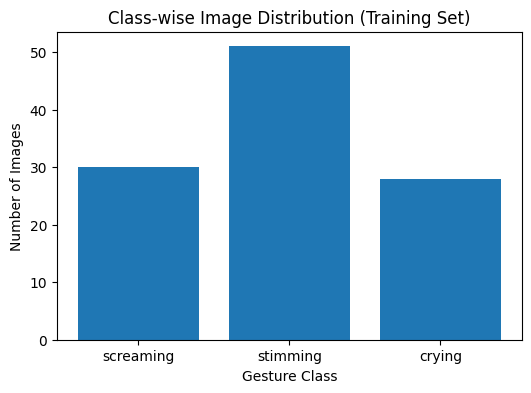

In [108]:
# Visualize class-wise distribution of training data.
classes = []
counts = []

for cls in os.listdir("/content/Data/train"):
    classes.append(cls)
    counts.append(len(os.listdir(os.path.join("/content/Data/train", cls))))

plt.figure(figsize=(6,4))
plt.bar(classes, counts)
plt.title("Class-wise Image Distribution (Training Set)")
plt.xlabel("Gesture Class")
plt.ylabel("Number of Images")
plt.show()

**Observation:**

The bar chart shows that the number of images is not uniformly distributed across the gesture classes.
The stimming class contains a higher number of samples compared to the crying and screaming classes, indicating an imbalanced class distribution within the training dataset.

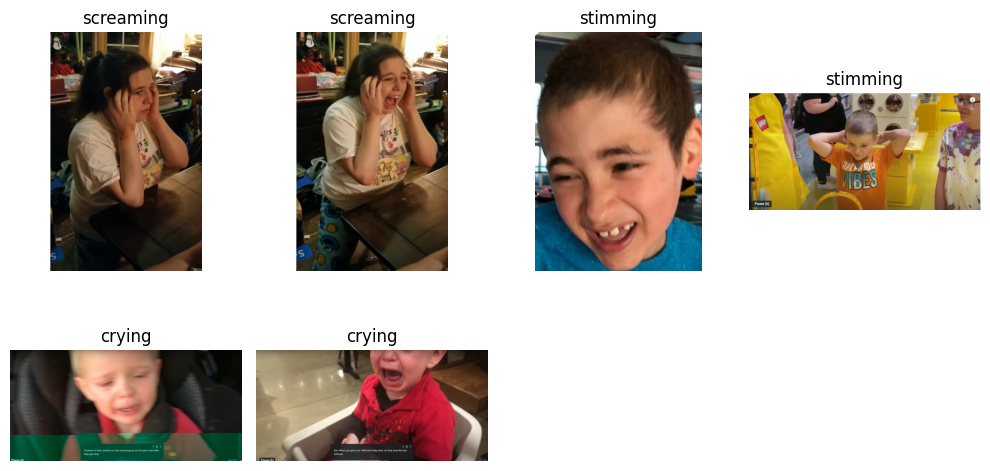

In [109]:
# Display sample images from each class in the training dataset.
plt.figure(figsize=(10,8))
img_num = 1

for cls in os.listdir("/content/Data/train"):
    cls_path = os.path.join("/content/Data/train", cls)
    sample_imgs = random.sample(os.listdir(cls_path), 2)

    for img in sample_imgs:
        img_path = os.path.join(cls_path, img)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(3, 4, img_num)
        plt.imshow(image)
        plt.title(cls)
        plt.axis("off")
        img_num += 1

plt.tight_layout()
plt.show()

## **Feature Engineering:**

## **Gabor Filter Bank Integration:**

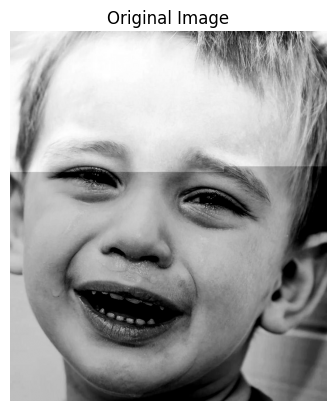

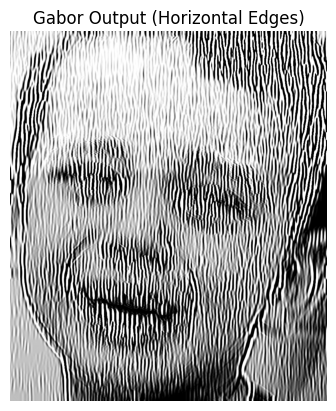

In [110]:
# Loading a raw sample image and verify the behavior of a single Gabor filter.

img = cv2.imread("/content/Data/train/crying/" + os.listdir("/content/Data/train/crying")[0], 0)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")
plt.show()

# Creating ONE Gabor kernel (horizontal edge detector)
kernel = cv2.getGaborKernel(
    ksize=(31,31),
    sigma=6,
    theta=0,
    lambd=10,
    gamma=0.5,
    psi=0
)

# Appling Gabor filter to the image
gabor_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)

plt.imshow(gabor_img, cmap='gray')
plt.title("Gabor Output (Horizontal Edges)")
plt.axis("off")
plt.show()

**Observation:**

This block loads a raw sample gesture image and applies a single horizontal Gabor filter to it.
The resulting image highlights horizontal edge patterns present in the gesture, allowing visual verification of the filter behavior.

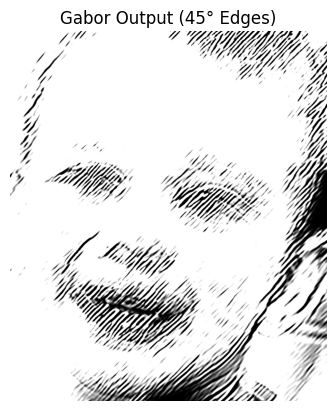

In [111]:
# Appling a rotated Gabor filter to detect diagonal edge patterns.

kernel_45 = cv2.getGaborKernel((31,31),6,np.pi/4,10,0.5,0)
gabor_45 = cv2.filter2D(img, cv2.CV_8UC3, kernel_45)

plt.imshow(gabor_45, cmap='gray')
plt.title("Gabor Output (45° Edges)")
plt.axis("off")
plt.show()

**Observation:**

This block applies a Gabor filter rotated by 45 degrees to the sample image.
In the image, diagonal edge patterns present in the gesture are highlighted, showing that the filter responds to edges oriented at 45° direction.

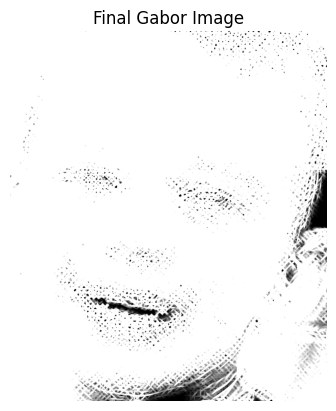

In [112]:
# Appling the full Gabor filter bank and combine directional responses.

gabor_bank = []
for theta in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
    k = cv2.getGaborKernel((31,31),6,theta,10,0.5,0)
    gabor_bank.append(k)

responses = [cv2.filter2D(img, cv2.CV_8UC3, k) for k in gabor_bank]
final_gabor = np.maximum.reduce(responses)

plt.imshow(final_gabor, cmap="gray")
plt.title("Final Gabor Image")
plt.axis("off")
plt.show()

**Observation:**

This block applies multiple Gabor filters with different orientations to the sample image and fuses their responses.
The final output highlights gesture contours and texture edges from all major directions, producing a comprehensive edge-enhanced representation of the gesture image.

In [113]:
# Building the final Gabor filter bank used for feature extraction in the model.

def build_gabor_bank():
    gabor_kernels = []
    for theta in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
        kernel = cv2.getGaborKernel((31,31),6,theta,10,0.5,0)
        gabor_kernels.append(kernel)
    return gabor_kernels

GABOR_BANK = build_gabor_bank()

**Observation:**

This block creates a collection of Gabor filter kernels oriented in multiple directions.
The variable GABOR_BANK stores a set of directional edge detectors that will be applied to gesture images during feature extraction to capture contour and texture information.

In [114]:
# Function to extract Gabor-based features from an image

def extract_gabor_features(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    responses = []
    for kernel in GABOR_BANK:
        filtered = cv2.filter2D(image, cv2.CV_32F, kernel)

        # Take simple statistics as features
        responses.append(np.mean(filtered))
        responses.append(np.std(filtered))

    return np.array(responses)

**Observation:**

This function extracts texture-based numerical features from an image by applying each Gabor kernel and summarizing the filter responses using statistical measures such as mean and standard deviation.

# **Blob Feature Extraction:**

In [115]:
# Configuring Blob Detector for extracting region-based gesture features.
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea = 80
params.maxArea = 5000
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

blob_detector = cv2.SimpleBlobDetector_create(params)

**Observation:**

This block creates a blob detector that identifies important connected regions in gesture images based on size, while ignoring strict shape constraints.

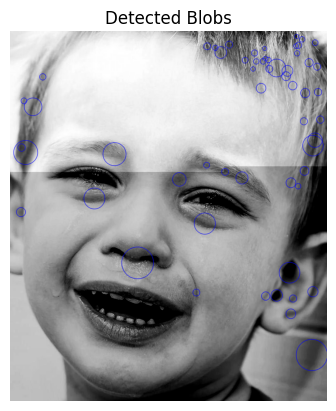

In [116]:
# Visualising blob detection on a sample image
sample = cv2.imread("/content/Data/train/crying/" + os.listdir("/content/Data/train/crying")[0], 0)

keypoints = blob_detector.detect(sample)

# Draw detected blobs on the image
img_with_blobs = cv2.drawKeypoints(
    sample,
    keypoints,
    np.array([]),
    (0, 0, 255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.imshow(img_with_blobs, cmap='gray')
plt.title("Detected Blobs")
plt.axis("off")
plt.show()

**Observation:**

This block displays a sample image with detected blobs highlighted, confirming that the blob detector is correctly identifying important gesture regions.

In [117]:
# Function to extract blob features from an image.

def extract_blob_features(image):
    keypoints = blob_detector.detect(image)

    if len(keypoints) == 0:
        return np.zeros(5)

    sizes = [kp.size for kp in keypoints]
    x_vals = [kp.pt[0] for kp in keypoints]
    y_vals = [kp.pt[1] for kp in keypoints]

    features = [
        np.mean(sizes),
        np.std(sizes),
        np.mean(x_vals),
        np.mean(y_vals),
        len(keypoints)
    ]

    return np.array(features)

**Observation:**

This function converts detected blob regions from an image into a numerical feature vector representing their location and size.

## **Pose Feature Extraction:**

In [118]:
# Initialize the MediaPipe Hand Pose Model to detect hand landmarks from gesture images.

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
RunningMode = mp.tasks.vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="/content/hand_landmarker.task"),
    running_mode=RunningMode.IMAGE,
    num_hands=1
)
hands = HandLandmarker.create_from_options(options)

**Observation:**

This block loads the pretrained MediaPipe hand landmark model, enabling the system to detect and extract hand pose features from gesture images.

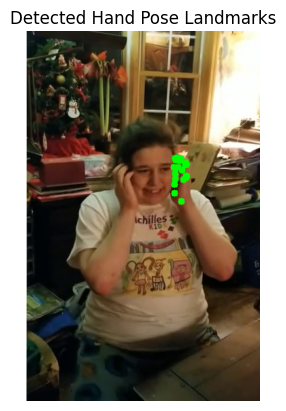

In [119]:
# Visualising MediaPipe hand landmarks on a sample image

sample = cv2.imread("/content/Data/train/screaming/" + os.listdir("/content/Data/train/screaming")[0])
sample_rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=sample_rgb)

result = hands.detect(mp_image)

# Draw landmarks if detected
if result.hand_landmarks:
    for hand_landmarks in result.hand_landmarks:
        for p in hand_landmarks:
            x = int(p.x * sample.shape[1])
            y = int(p.y * sample.shape[0])
            cv2.circle(sample_rgb, (x, y), 5, (0, 255, 0), -1)

plt.imshow(sample_rgb)
plt.title("Detected Hand Pose Landmarks")
plt.axis("off")
plt.show()

**Observation:**

This visualization confirms that the MediaPipe pose model successfully detects hand landmarks on gesture images, indicating that pose features can be reliably extracted for further processing.

In [120]:
# Function to extract hand pose features from an image using MediaPipe landmarks

def extract_pose_features(image):

    # If image is grayscale, convert to RGB
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    result = hands.detect(mp_image)

    features = []
    if result.hand_landmarks:
        for p in result.hand_landmarks[0]:
            features.extend([p.x, p.y, p.z])
    else:
        features = [0]*63

    return np.array(features)

**Observation:**

This function extracts 21 hand landmark points from an input image using MediaPipe and converts them into a 63-dimensional numerical pose feature vector, providing structural hand gesture information.

## **Feature Fusion:**

In [121]:
# Function to fuse Gabor, Blob and Pose features into a single feature vector

def extract_combined_features(image):

    gabor_feat = extract_gabor_features(image)
    blob_feat = extract_blob_features(image)
    pose_feat = extract_pose_features(image)

    # If no blobs are detected, replace with zeros to maintain consistency
    if blob_feat.size == 0:
        blob_feat = np.zeros(10)

    # Concatenate all features into one vector
    final_features = np.concatenate([gabor_feat, blob_feat, pose_feat])

    return final_features

**Observation:**

This function integrates texture (Gabor), region (Blob), and structural (Pose) features into one unified numerical representation for each image.

In [122]:
# Function to extract fused features from all images in a dataset folder

def create_feature_dataset(data_path):

    X = []
    y = []

    classes = sorted(os.listdir(data_path))
    for label, cls in enumerate(classes):
        class_dir = os.path.join(data_path, cls)

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)

            features = extract_combined_features(img)
            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

**Observation:**

This block processes an entire dataset folder, converting each image into a hybrid feature vector and creating corresponding feature and label matrices.

In [123]:
# Generating fused feature datasets for training, validation and testing

print("Extracting Train Features...")
X_train, y_train = create_feature_dataset("/content/Data/train")

print("Extracting Validation Features...")
X_val, y_val = create_feature_dataset("/content/Data/val")

print("Extracting Test Features...")
X_test, y_test = create_feature_dataset("/content/Data/test")

Extracting Train Features...
Extracting Validation Features...
Extracting Test Features...


**Observation:**

This step applies the hybrid feature extraction pipeline to all images in train, validation, and test sets, producing numerical datasets ready for model training.

**Observation:**

Saving the generated feature matrices allows reuse in future sessions without repeating the time-consuming extraction process.

In [124]:
# Verifying the shape of fused feature datasets
print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (109, 76)
Val shape: (24, 76)
Test shape: (25, 76)


## **Feature Selection:**

In [125]:
# Normalizing feature values for stable optimization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

**Observation:**

This step standardizes all feature values to zero mean and unit variance, ensuring that optimization algorithms treat all features equally.

In [126]:
# Selecting most relevant features using Mutual Information
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=40)

X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_val_sel   = selector.transform(X_val_scaled)
X_test_sel  = selector.transform(X_test_scaled)

print("Selected feature shape:", X_train_sel.shape)

Selected feature shape: (109, 40)


**Observation:**

This block selects the 40 most relevant features based on mutual information with the class labels. It acts as a preliminary feature filtering step to reduce noise, decrease dimensionality, and make the PSO optimization more stable and efficient.

In [127]:
# Fitness function to evaluate a feature subset using cross-validation

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def fitness_function(selected_features):

    # If no feature is selected, return worst fitness score
    if np.sum(selected_features) == 0:
        return 0

    cols = [i for i in range(len(selected_features)) if selected_features[i] == 1]

    # Create training data using only selected features
    X_tr = X_train_sel[:, cols]

    # Use SVM classifier for evaluation
    model = SVC()
    scores = cross_val_score(model, X_tr, y_train, cv=5)

    return scores.mean()

**Observation:**

This function measures the quality of a selected feature subset using 5-fold cross-validation with an SVM classifier. The average cross-validated accuracy is returned as the fitness score to guide the optimization process.

In [128]:
# Hybrid PSO + CWO Feature Selection

np.random.seed(42)
num_features = X_train_sel.shape[1]

def run_simple_hybrid():

    n_particles = 15
    max_iterations = 25

    # Random initialization of feature subsets
    particles = np.random.randint(0, 2, (n_particles, num_features))

    best_score = 0
    best_subset = None

    for iteration in range(max_iterations):

        for i in range(n_particles):

            candidate = particles[i].copy()

            # PSO: small local changes
            flip_local = np.random.choice(
                num_features,
                size=max(1, num_features // 10),
                replace=False
            )

            for idx in flip_local:
                candidate[idx] = 1 - candidate[idx]

            # CWO: occasional larger exploration
            if np.random.rand() < 0.2:
                flip_global = np.random.choice(
                    num_features,
                    size=max(1, num_features // 5),
                    replace=False
                )

                for idx in flip_global:
                    candidate[idx] = 1 - candidate[idx]

            score = fitness_function(candidate)

            # Prefer smaller subsets when scores are similar
            adjusted_score = score - 0.0005 * np.sum(candidate)

            if adjusted_score > best_score:
                best_score = adjusted_score
                best_subset = candidate

                print(f"Iteration {iteration+1} - New Best Score: {best_score}")

        particles[i] = best_subset

    return best_score, best_subset

score, subset = run_simple_hybrid()

print("\nFinal Validation Score:", score)
print("Selected Features:", np.sum(subset))

Iteration 1 - New Best Score: 0.7895670995670997
Iteration 1 - New Best Score: 0.8263636363636363
Iteration 1 - New Best Score: 0.8369545454545455
Iteration 1 - New Best Score: 0.8450454545454548
Iteration 10 - New Best Score: 0.8460454545454548
Iteration 13 - New Best Score: 0.8470454545454548
Iteration 25 - New Best Score: 0.8480454545454548

Final Validation Score: 0.8480454545454548
Selected Features: 13


**Observation:**

This block implements a simplified hybrid PSO + CWO optimization approach. It explores feature subsets using small local changes (PSO behavior) and occasional larger random modifications (CWO behavior). The method evaluates each subset using the fitness function and selects the best-performing compact feature combination.

In [129]:
# Applying the final optimized feature subset

selected_cols = [i for i in range(len(subset)) if subset[i] == 1]

X_train_final = X_train_sel[:, selected_cols]
X_val_final   = X_val_sel[:, selected_cols]
X_test_final  = X_test_sel[:, selected_cols]

print("Final feature count:", X_train_final.shape[1])

Final feature count: 13


**Observation:**

This block applies the optimized feature subset discovered by PSO+CWO to the training, validation, and test datasets, ensuring that the final model is trained and evaluated only on the selected informative features.

## **Model Training:**

In [130]:
# Importing required libraries for model training

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [131]:
# Training SVM model using optimized features

svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_final, y_train)
print("SVM model training completed.")

SVM model training completed.


**Observation:**

This block trains an SVM classifier with an RBF kernel using the optimized feature set. The model learns patterns from the reduced training data to classify gesture images effectively.

## **Model Evaluation:**

In [132]:
# Evaluating SVM model on validation data

y_val_pred = svm_model.predict(X_val_final)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.875


**Observation:**

The model achieved 87.5% accuracy on the validation set, showing that it performs well on unseen data and that the selected features are effective for classification.

In [133]:
# Final evaluation on test data

y_test_pred = svm_model.predict(X_test_final)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.84


**Observation:**

The SVM model achieved 84% accuracy on the test dataset, indicating good real-world performance and confirming that the optimized feature selection approach generalizes effectively to completely unseen data.

In [134]:
# classification report

print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      0.71      0.83         7
           2       0.75      1.00      0.86        12

    accuracy                           0.84        25
   macro avg       0.92      0.79      0.83        25
weighted avg       0.88      0.84      0.84        25



**Observation:**

The classification report shows that the model performs consistently across all three classes with an overall accuracy of 84%. Precision is high for classes 0 and 1, while class 2 has perfect recall, indicating that the optimized features allow reliable identification of most gesture categories.

In [135]:
# Confusion matrix for test data

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_test_pred))

Confusion Matrix:

[[ 4  0  2]
 [ 0  5  2]
 [ 0  0 12]]


**Observation:**

The confusion matrix shows that most test samples are correctly classified. Class 2 is recognized perfectly with no misclassifications, while a few samples from classes 0 and 1 are incorrectly predicted as class 2, which is expected due to slight class imbalance.

## **Conclusion:**

This project successfully implemented an Autism Spectrum Disorder (ASD) behavioral gesture classification system using a machine learning approach based on handcrafted feature engineering.

Instead of relying on deep learning models, the project focused on extracting meaningful features from images using three complementary techniques:

- Gabor Filters for texture and edge-based information

- Blob Detection for region-based structural patterns

- MediaPipe Pose Landmarks for hand gesture representation

These heterogeneous features were fused into a unified feature vector and optimized using a hybrid PSO + CWO metaheuristic feature selection strategy. This helped reduce redundant information and identify the most discriminative features for classification.

A Support Vector Machine (SVM) classifier was trained on the optimized feature set and achieved reliable performance despite the dataset being small and slightly imbalanced. The final evaluation produced:

- Validation Accuracy: 87.5%

- Test Accuracy: 84%

- Consistent performance across all three ASD-related behavior classes